In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [5]:

def load_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    # Download and load the training data
    train_dataset = datasets.MNIST(root='./data', 
                             train=True, 
                             download=True, 
                             transform=transform
                             )
    return train_dataset

def generate_random_image(train_dataset):
    images = []
    labels = []
    for _ in range(4):
        idx = torch.randint(len(train_dataset), size=(1,)).item()
        img, label = train_dataset[idx]
        images.append(img.squeeze().numpy())
        labels.append(label)

# Concatenate images into a 2x2 grid
    top_row = np.concatenate([images[0], images[1]], axis=1)
    bottom_row = np.concatenate([images[2], images[3]], axis=1)
    final_image = np.concatenate([top_row, bottom_row], axis=0)
    return final_image, labels

def split_image_to_patches(image):
    blocks = []  # Initialize empty list to store blocks

    for i in range(4):
        for j in range(4):
            # Extract 14x14 block
            block = image[i*14:(i+1)*14, j*14:(j+1)*14]
            blocks.append(block)  # Add block to our list
    return blocks

def create_dataset(num_images, train_dataset):
    dataset = []
    
    for _ in range(num_images):
        image, labels = generate_random_image(train_dataset)
        dataset.append((image, labels))
    
    return dataset



In [6]:
train_dataset = load_dataset()
dataset = create_dataset(10000, train_dataset)
print(dataset[0]) #numpy array followed by array of the 4 labels

(array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], shape=(56, 56), dtype=float32), [6, 2, 0, 3])


In [7]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_label_pairs):
        self.image_label_pairs = image_label_pairs
    
    def __len__(self):
        return len(self.image_label_pairs)
    
    def __getitem__(self, idx):
        image, label = self.image_label_pairs[idx]

        patches_array = self.split_image_to_patches(image)
        patches_tensor = [torch.tensor(patch.flatten(), dtype=torch.float32) for patch in patches_array] #array of 16 with each tensor[196]
        image_tensor = torch.stack(patches_tensor) # tensor [16,196]
        #turn label array of integers into tensor:
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        
        return {
            'image': image_tensor,
            'label': label_tensor,
        }
    
    def split_image_to_patches(self, image):
        blocks = []  # Initialize empty list to store blocks

        for i in range(4):
            for j in range(4):
                # Extract 14x14 block
                block = image[i*14:(i+1)*14, j*14:(j+1)*14]
                blocks.append(block)  # Add block to our list
        return blocks


In [8]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [9]:
class Embedding_Layer(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(Embedding_Layer, self).__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
        #input dimension is the dimension of each patch
        #embedding_dim is the dimensionality that each patch is embedded onto
    def forward(self, x):
        return self.embedding(x)

class Attention_Layer(nn.Module):
    def __init__(self, d_model, num_heads):
        super(Attention_Layer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        self.W_q = torch.nn.Linear(d_model, d_model)
        self.W_k = torch.nn.Linear(d_model, d_model)
        self.W_v = torch.nn.Linear(d_model, d_model)
    
    def forward(self, query_input, key_input, value_input, mask=None):
        dim_k = self.d_model // self.num_heads
        query = self.W_q(query_input)
        key = self.W_k(key_input)
        value = self.W_v(value_input)
        
        query_key = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(dim_k)
        prob = query_key.softmax(dim=-1)
        weighted_attention = torch.matmul(prob, value)
        return weighted_attention, prob
    

class PositionalEncoding(nn.Module):
    # Just add a randomised matrix to 
    def __init__(self, first_dim, embedding_dimension):
        super(PositionalEncoding, self).__init__()
        self.first_dim = first_dim
        self.embedding_dimension = embedding_dimension
        self.positional_encoding = torch.nn.Parameter(torch.rand(first_dim, embedding_dimension))

    def forward(self, x):
        return x + self.positional_encoding
    

class FeedForwardLayer(nn.Module):
    def __init__(self, embedding_dim, hidden_layer_dim):
        super(FeedForwardLayer, self).__init__()
        self.ff1 = torch.nn.Linear(embedding_dim, hidden_layer_dim)
        self.ff2 = torch.nn.Linear(hidden_layer_dim, embedding_dim)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        return self.ff2(self.relu(self.ff1(x)))
    

class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2



class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, n_loops, feed_forward, attention_layer, positional_encoding):
        super(Encoder, self).__init__()
        self.embedding_layer = Embedding_Layer(input_dim, embedding_dim)
        self.positional_encoding = positional_encoding
        self.attn_layer = attention_layer
        self.FF_layer = feed_forward
        self.embedding_dim = embedding_dim
        self.input_dim = input_dim
        self.n_loops = n_loops


        #remove below when doing full model
        self.intermediate = torch.nn.Linear(64*16, 40)
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.final = torch.nn.Linear(40, 40)
    
    def get_qkv(self, q_input, k_input, v_input, embedding_dim):
        query = torch.nn.Linear(q_input.size(-1), embedding_dim)
        key = torch.nn.Linear(k_input.size(-1), embedding_dim)
        value = torch.nn.Linear(v_input.size(-1), embedding_dim)
        return query, key, value
    
    def LayerNorm(self, x, eps=1e-6):
        features = x.size(-1)
        a_2 = torch.nn.Parameter(torch.ones(features)) #shape (64,)
        b_2 = torch.nn.Parameter(torch.zeros(features)) #shape (64,)

        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)

        return a_2 * (x - mean) / (std + eps) + b_2

    
    def forward(self, x):
        embedding = self.embedding_layer(x)

        embedding = self.positional_encoding(embedding)

        # for i in range(self.n_loops): #To do, to add loops, we must clone Encoder layers which consist of ff + attn
        # query, key, value = self.get_qkv(x, x, x, self.embedding_dim)
        attn, prob = self.attn_layer.forward(embedding, embedding, embedding, None)
        x = attn + self.LayerNorm(attn)
        x = self.FF_layer(x)
        x = x + self.LayerNorm(x)

        return x
    
    def predict_single_integer(self, x):
        if len(x.shape) == 2:  # Single instance case [16, 64]
            x = x.unsqueeze(0)  # Add batch dimension [1, 16, 64]
        
        # Now x is [batch, 16, 64] in both cases
        x = x.reshape(x.size(0), -1)  # Flatten to [batch, 1024]
        flatten = self.flatten(x)
        x = self.intermediate(flatten)
        x = self.relu(x)
        return self.final(x)
    
    def predict_numbers(self, x):
        if len(x.shape) == 2:  # Single instance case [16, 64]
            x = x.unsqueeze(0)  # Add batch dimension [1, 16, 64]
        
        # Now x is [batch, 16, 64] in both cases
        x = x.reshape(x.size(0), -1)  # Flatten to [batch, 1024]
        flatten = self.flatten(x)
        x = self.intermediate(flatten)
        x = self.relu(x)
        x = self.final(x)
        # Reshape to [batch, 4, 10] for 4 digit predictions
        return x.view(x.size(0), 4, 10)




In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

         # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        self.attn_probs = None

                # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
    
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output, attn_probs
    
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output, attn_probs = self.scaled_dot_product_attention(Q, K, V, mask)
        self.attn_probs = attn_probs
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output, attn_probs

        


In [44]:
device = torch.device("cpu")
embedding_dim = 64
hidden_layer_dimension = 32
input_dimension = 196
epochs = 20
num_patches = 16
fflayer = FeedForwardLayer(embedding_dim, hidden_layer_dimension)
attention_layer = MultiHeadAttention(embedding_dim, 4)
positional_encoding = PositionalEncoding(num_patches, embedding_dim)
model = Encoder(input_dimension, embedding_dim, 1, fflayer,attention_layer=attention_layer, positional_encoding=positional_encoding)
criterion = torch.nn.CrossEntropyLoss()  # Cross-Entropy Loss for classification
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), learning_rate)


dataset_ready = ImageDataset(dataset)
batch_size = 20
dataloader = torch.utils.data.DataLoader(
    dataset_ready,
    batch_size=batch_size,
    shuffle=True,
)



def train():
    model.train()
    total_loss = 0
    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm.tqdm(
            dataloader, desc=f"Epoch {epoch + 1}/{epochs}"
        )

        for batch_idx, batch in enumerate(progress_bar):
            
            batch_loss = 0
            image, label = batch['image'].to(device), batch['label'].to(device)

            first_labels = label[:, 0]
            optimizer.zero_grad()

            output = model.forward(image)
            # single_number = model.predict_single_integer(output)
            predictions = model.predict_numbers(output)  # Shape: [batch, 4, 10]
            
             # Calculate loss for all 4 digits
            batch_loss = sum(criterion(predictions[:, i], label[:, i]) for i in range(4))


            if batch_idx == 0:  # Print only first batch of each epoch
                pred_digits = torch.argmax(predictions[0], dim=1)
                print(f"Predictions: {pred_digits}")
                print(f"Actual labels: {label[0]}")

            progress_bar.set_postfix({"batch_loss": batch_loss.item() /  batch_size})

            epoch_loss += batch_loss.item()
            total_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
        
        epoch_loss = epoch_loss / len(dataloader.dataset)
        # total_loss += epoch_loss
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
        print(f"Total {epoch + 1}/{epochs}, Loss: {total_loss / (epoch + 1):.4f}")

        
train()



Epoch 1/20:   5%|▍         | 23/500 [00:00<00:04, 109.25it/s, batch_loss=0.457]

Predictions: tensor([0, 5, 9, 4])
Actual labels: tensor([1, 4, 6, 6])


Epoch 1/20: 100%|██████████| 500/500 [00:04<00:00, 118.05it/s, batch_loss=0.443]


Epoch 1/20, Loss: 0.4568
Total 1/20, Loss: 4567.8609


Epoch 2/20:   3%|▎         | 15/500 [00:00<00:03, 149.76it/s, batch_loss=0.449]

Predictions: tensor([7, 0, 0, 7])
Actual labels: tensor([3, 7, 0, 3])


Epoch 2/20: 100%|██████████| 500/500 [00:04<00:00, 118.01it/s, batch_loss=0.423]


Epoch 2/20, Loss: 0.4417
Total 2/20, Loss: 4492.2141


Epoch 3/20:   2%|▏         | 12/500 [00:00<00:04, 118.95it/s, batch_loss=0.43] 

Predictions: tensor([9, 1, 1, 1])
Actual labels: tensor([4, 0, 1, 7])


Epoch 3/20: 100%|██████████| 500/500 [00:04<00:00, 120.48it/s, batch_loss=0.409]


Epoch 3/20, Loss: 0.4218
Total 3/20, Loss: 4400.7300


Epoch 4/20:   3%|▎         | 14/500 [00:00<00:03, 138.01it/s, batch_loss=0.403]

Predictions: tensor([1, 1, 1, 1])
Actual labels: tensor([1, 5, 5, 1])


Epoch 4/20: 100%|██████████| 500/500 [00:04<00:00, 120.18it/s, batch_loss=0.408]


Epoch 4/20, Loss: 0.4010
Total 4/20, Loss: 4303.0923


Epoch 5/20:   1%|          | 3/500 [00:00<00:16, 29.25it/s, batch_loss=0.381]

Predictions: tensor([4, 4, 4, 4])
Actual labels: tensor([6, 9, 4, 3])


Epoch 5/20: 100%|██████████| 500/500 [00:04<00:00, 113.69it/s, batch_loss=0.316]


Epoch 5/20, Loss: 0.3575
Total 5/20, Loss: 4157.5482


Epoch 6/20:   1%|          | 5/500 [00:00<00:11, 42.74it/s, batch_loss=0.303]

Predictions: tensor([4, 6, 4, 4])
Actual labels: tensor([8, 6, 3, 4])


Epoch 6/20: 100%|██████████| 500/500 [00:04<00:00, 114.28it/s, batch_loss=0.275]


Epoch 6/20, Loss: 0.2865
Total 6/20, Loss: 3942.1848


Epoch 7/20:   3%|▎         | 14/500 [00:00<00:03, 135.57it/s, batch_loss=0.275]

Predictions: tensor([2, 9, 6, 9])
Actual labels: tensor([2, 9, 6, 7])


Epoch 7/20: 100%|██████████| 500/500 [00:04<00:00, 120.15it/s, batch_loss=0.199]


Epoch 7/20, Loss: 0.2204
Total 7/20, Loss: 3693.8262


Epoch 8/20:   3%|▎         | 15/500 [00:00<00:03, 148.13it/s, batch_loss=0.201]

Predictions: tensor([7, 4, 6, 3])
Actual labels: tensor([8, 4, 6, 3])


Epoch 8/20: 100%|██████████| 500/500 [00:04<00:00, 117.69it/s, batch_loss=0.162]


Epoch 8/20, Loss: 0.1744
Total 8/20, Loss: 3450.0401


Epoch 9/20:   3%|▎         | 15/500 [00:00<00:03, 137.68it/s, batch_loss=0.164]

Predictions: tensor([0, 7, 0, 3])
Actual labels: tensor([0, 7, 0, 8])


Epoch 9/20: 100%|██████████| 500/500 [00:03<00:00, 125.62it/s, batch_loss=0.133] 


Epoch 9/20, Loss: 0.1452
Total 9/20, Loss: 3228.0203


Epoch 10/20:   2%|▏         | 8/500 [00:00<00:06, 74.09it/s, batch_loss=0.125]

Predictions: tensor([3, 7, 5, 9])
Actual labels: tensor([8, 9, 5, 7])


Epoch 10/20: 100%|██████████| 500/500 [00:04<00:00, 115.67it/s, batch_loss=0.136] 


Epoch 10/20, Loss: 0.1254
Total 10/20, Loss: 3030.5870


Epoch 11/20:   1%|▏         | 7/500 [00:00<00:07, 68.83it/s, batch_loss=0.0896]

Predictions: tensor([2, 8, 0, 3])
Actual labels: tensor([2, 8, 0, 3])


Epoch 11/20: 100%|██████████| 500/500 [00:04<00:00, 115.05it/s, batch_loss=0.138] 


Epoch 11/20, Loss: 0.1106
Total 11/20, Loss: 2855.6058


Epoch 12/20:   3%|▎         | 16/500 [00:00<00:03, 153.55it/s, batch_loss=0.122] 

Predictions: tensor([9, 8, 0, 1])
Actual labels: tensor([9, 8, 0, 1])


Epoch 12/20: 100%|██████████| 500/500 [00:04<00:00, 116.89it/s, batch_loss=0.0588]


Epoch 12/20, Loss: 0.1001
Total 12/20, Loss: 2701.0542


Epoch 13/20:   3%|▎         | 14/500 [00:00<00:03, 136.47it/s, batch_loss=0.0995]

Predictions: tensor([7, 6, 9, 4])
Actual labels: tensor([7, 5, 9, 4])


Epoch 13/20: 100%|██████████| 500/500 [00:04<00:00, 123.73it/s, batch_loss=0.0792]


Epoch 13/20, Loss: 0.0917
Total 13/20, Loss: 2563.8439


Epoch 14/20:   3%|▎         | 16/500 [00:00<00:03, 151.14it/s, batch_loss=0.084] 

Predictions: tensor([2, 4, 7, 7])
Actual labels: tensor([2, 4, 7, 7])


Epoch 14/20: 100%|██████████| 500/500 [00:04<00:00, 122.81it/s, batch_loss=0.074] 


Epoch 14/20, Loss: 0.0858
Total 14/20, Loss: 2441.9929


Epoch 15/20:   2%|▏         | 10/500 [00:00<00:05, 92.16it/s, batch_loss=0.0621]

Predictions: tensor([1, 8, 1, 2])
Actual labels: tensor([1, 8, 1, 2])


Epoch 15/20: 100%|██████████| 500/500 [00:04<00:00, 117.15it/s, batch_loss=0.0827]


Epoch 15/20, Loss: 0.0807
Total 15/20, Loss: 2332.9646


Epoch 16/20:   2%|▏         | 12/500 [00:00<00:04, 117.05it/s, batch_loss=0.0585]

Predictions: tensor([7, 7, 0, 2])
Actual labels: tensor([7, 7, 0, 2])


Epoch 16/20: 100%|██████████| 500/500 [00:04<00:00, 115.75it/s, batch_loss=0.0728]


Epoch 16/20, Loss: 0.0767
Total 16/20, Loss: 2235.1223


Epoch 17/20:   1%|▏         | 7/500 [00:00<00:07, 67.13it/s, batch_loss=0.0496]

Predictions: tensor([3, 9, 5, 9])
Actual labels: tensor([5, 9, 5, 9])


Epoch 17/20: 100%|██████████| 500/500 [00:05<00:00, 89.41it/s, batch_loss=0.0523] 


Epoch 17/20, Loss: 0.0733
Total 17/20, Loss: 2146.7338


Epoch 18/20:   3%|▎         | 15/500 [00:00<00:03, 148.15it/s, batch_loss=0.0691]

Predictions: tensor([4, 5, 4, 0])
Actual labels: tensor([4, 5, 4, 0])


Epoch 18/20: 100%|██████████| 500/500 [00:03<00:00, 129.23it/s, batch_loss=0.0627]


Epoch 18/20, Loss: 0.0706
Total 18/20, Loss: 2066.6710


Epoch 19/20:   3%|▎         | 17/500 [00:00<00:03, 160.61it/s, batch_loss=0.0903]

Predictions: tensor([4, 0, 0, 3])
Actual labels: tensor([4, 0, 0, 3])


Epoch 19/20: 100%|██████████| 500/500 [00:04<00:00, 114.31it/s, batch_loss=0.0839]


Epoch 19/20, Loss: 0.0682
Total 19/20, Loss: 1993.7969


Epoch 20/20:   3%|▎         | 17/500 [00:00<00:02, 168.82it/s, batch_loss=0.102] 

Predictions: tensor([1, 2, 8, 9])
Actual labels: tensor([1, 2, 8, 9])


Epoch 20/20: 100%|██████████| 500/500 [00:04<00:00, 119.89it/s, batch_loss=0.0632]

Epoch 20/20, Loss: 0.0657
Total 20/20, Loss: 1926.9537


In [71]:
def visualize_attention(attn_probs, head=0):
    """
    Visualize attention probabilities for a specific head
    
    Args:
        attn_probs: Tensor of shape [batch_size, num_heads, seq_len, seq_len]
        head: Which attention head to visualize (default=0)
    """
    # Take first batch and specified head
    attn_map = attn_probs[0, head].detach().cpu().numpy()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(attn_map, cmap='viridis')
    plt.colorbar()
    plt.title(f'Attention Head {head}')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.show()

# To visualize all heads at once
def visualize_all_heads(attn_probs):
    """
    Visualize all attention heads
    
    Args:
        attn_probs: Tensor of shape [batch_size, num_heads, seq_len, dim_model]
    """
    num_heads = attn_probs.size(1)
    fig, axes = plt.subplots(2, num_heads//2, figsize=(15, 8))
    
    for head in range(num_heads):
        attn_map = attn_probs[0, head].detach().cpu().numpy()
        ax = axes[head//2, head%2]  # Correctly index into 2D axes array
        im = ax.imshow(attn_map, cmap='viridis')
        ax.set_title(f'Head {head}')
        
    plt.tight_layout()
    # Create a single colorbar for the entire figure
    fig.colorbar(im, ax=axes)
    plt.show()

def do_test_new(model):
    image, label = generate_random_image(train_dataset)
    plt.imshow(image, cmap='gray')
    plt.title(f"Labels: {label}")
    plt.show()

    patches_array = split_image_to_patches(image)
    patches_tensor = [torch.tensor(patch.flatten(), dtype=torch.float32) for patch in patches_array]
    image_tensor = torch.stack(patches_tensor).unsqueeze(0)  # Add batch dimension [1, 16, 196]
    # print(image_tensor.shape)
    model.eval()
    output = model.forward(image_tensor)
    
    # Get attention probabilities from the last forward pass
    attn_probs = model.attn_layer.attn_probs
    
    # # Visualize attention patterns
    visualize_all_heads(attn_probs)
    
    # # Continue with your existing prediction code
    single_number = model.predict_numbers(output)
    prediction = torch.argmax(single_number, dim=2)
    print(prediction, 'prediction', "should equal", label)

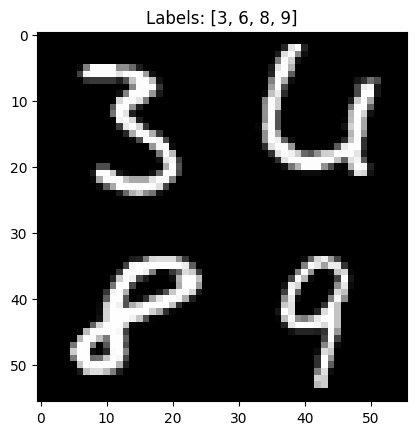

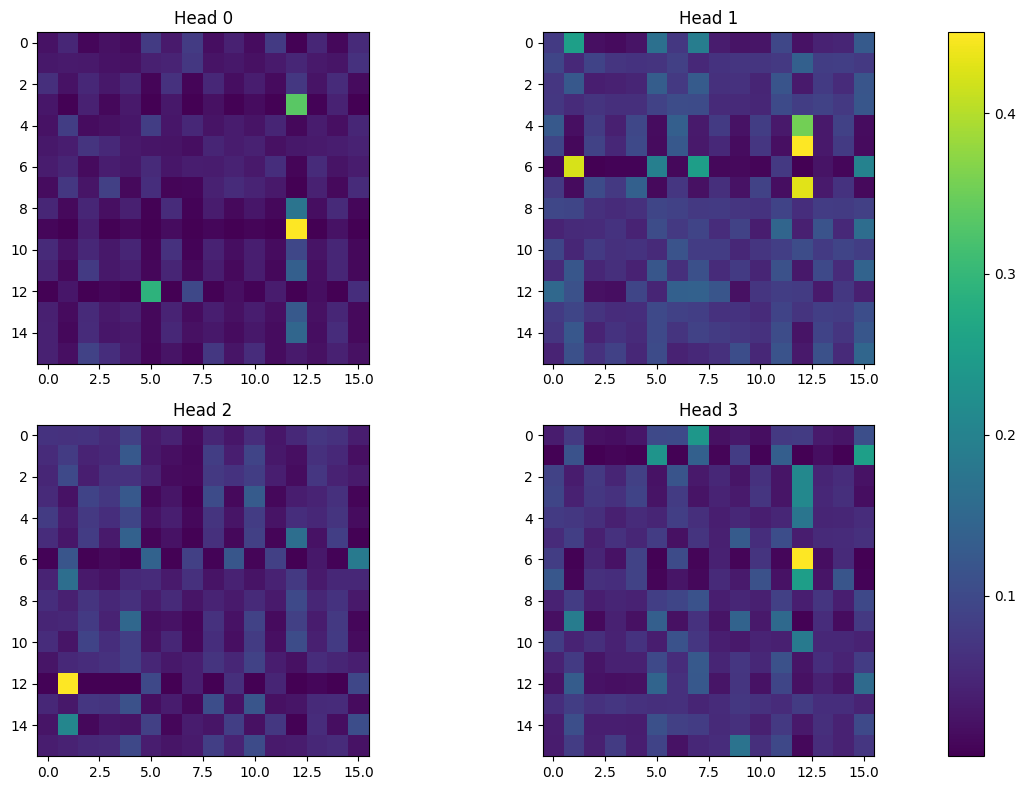

tensor([[3, 6, 8, 9]]) prediction should equal [3, 6, 8, 9]


In [72]:
do_test_new(model)

In [ ]:
class Decoder(nn.Module):
     def __init__(self, encoder_output, output_shifted_right, input_dim, embedding_dim, n_loops, feed_forward, attention_layer, positional_encoding):
        super(Decoder, self).__init__()
        self.embedding_layer = Embedding_Layer(input_dim, embedding_dim)
        self.positional_encoding = positional_encoding
        self.attn_layer = attention_layer
        self.FF_layer = feed_forward
        self.embedding_dim = embedding_dim
        self.input_dim = input_dim
        self.n_loops = n_loops


     def forward(self, x):
        embedding = self.embedding_layer(x)
        embedding = self.positional_encoding(embedding)

        


    
